In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Conv2DTranspose, Input, MaxPooling2D,
                                     concatenate)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-12-19 09:30:30.263637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 09:30:30.263702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 09:30:30.264737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 09:30:30.271775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 09:30:32.312378: W tensorflow/compiler/tf2

In [2]:
os.makedirs('figs', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('history', exist_ok=True)

# **Load image's path and mask's path**

In [3]:
EXT = "png"
IMG_SIZE = (256, 256)
NUM_CLASSES = 2

In [4]:
input_dir = f"../data/{EXT}/train/image/"
target_dir = f"../data/{EXT}/train/gt/"

train_files = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(EXT)])

train_mask_files = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(EXT) and not fname.startswith(".")])

In [5]:
input_dir = f"../data/{EXT}/test/image/"
target_dir = f"../data/{EXT}/test/gt/"

test_files = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(EXT)])

test_mask_files = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(EXT) and not fname.startswith(".")])

In [6]:
input_dir = f"../data/{EXT}/valid/image/"
target_dir = f"../data/{EXT}/valid/gt/"

valid_files = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(EXT)])

valid_mask_files = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(EXT) and not fname.startswith(".")])

In [7]:
len(train_files), len(test_files), len(valid_files)

(2174, 912, 323)

In [8]:
len(train_mask_files), len(test_mask_files), len(valid_mask_files)

(2174, 912, 323)

# **Data Visualization**

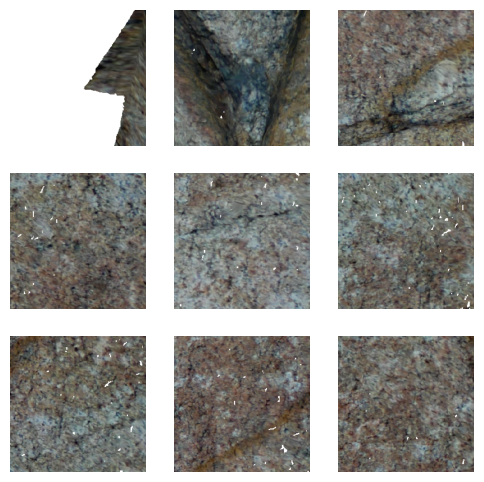

In [9]:
# Let's plot some samples
rows, cols = 3, 3
fig = plt.figure(figsize=(6, 6))

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    msk_path = train_mask_files[i]
    img = imread(img_path)
    msk = imread(msk_path)
    plt.imshow(img[:, :, :3])
    plt.axis('off')
    plt.grid([])

plt.show()

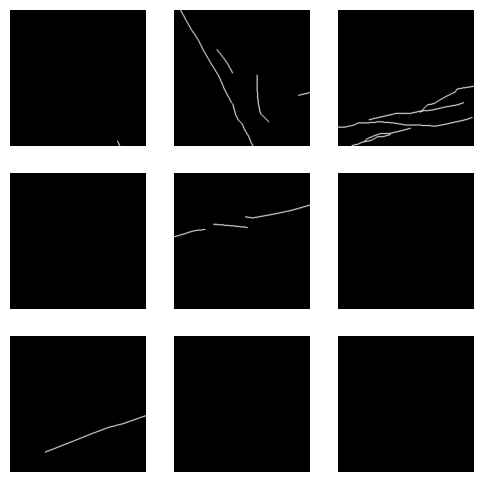

In [10]:
# Let's plot some samples
rows, cols = 3, 3
fig = plt.figure(figsize=(6, 6))

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    msk_path = train_mask_files[i]
    img = imread(img_path)
    msk = imread(msk_path)
    plt.imshow(msk, cmap='Greys_r')
    plt.axis('off')
    plt.grid([])

plt.show()

# **Create data frame and split data on train set, validation set and test set**

In [11]:
df_train = pd.DataFrame(data={"filename": train_files, 'mask': train_mask_files})
df_test = pd.DataFrame(data={"filename": test_files, 'mask': test_mask_files})
df_val = pd.DataFrame(data={"filename": valid_files, 'mask': valid_mask_files})

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2174, 2)
(323, 2)
(912, 2)


In [12]:
df_train.head()

filename  \
0     ../data/png/train/image/Site_A_1.png   
1    ../data/png/train/image/Site_A_10.png   
2   ../data/png/train/image/Site_A_100.png   
3  ../data/png/train/image/Site_A_1000.png   
4  ../data/png/train/image/Site_A_1001.png   

                                   mask  
0     ../data/png/train/gt/Site_A_1.png  
1    ../data/png/train/gt/Site_A_10.png  
2   ../data/png/train/gt/Site_A_100.png  
3  ../data/png/train/gt/Site_A_1000.png  
4  ../data/png/train/gt/Site_A_1001.png

# **Data genertator, data augmentation and adjust data**

In [39]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgba",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256, 1),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="filename",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        # preprocessing_function=preprocess,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        # preprocessing_function=preprocess,
        seed=seed
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

def adjust_data(img, mask):
    img = img / 255

    mask = mask / 255
    mask[mask > 0.01] = 1
    mask[mask <= 0.01] = 0

    return (img, mask)

# **Define loss function and metrics**

In [45]:
# Take long time
means = []
for i, p in enumerate(df_train['mask']):
    mask = imread(p)
    _, mask = adjust_data(0, mask)
    arr = np.where( mask == 1,1,0)
    means.append(arr.mean())

non_frac_wt = sum(means)/len(means)
frac_wt = 1 - non_frac_wt

frac_wt, non_frac_wt (img, mask)


(0.9846228184564023, 0.01537718154359763)

In [47]:
# (0.9846228184564023, 0.01537718154359763)
non_frac_wt = 0.02
frac_wt = 1 - non_frac_wt

In [49]:
smooth=100

def wt_cross_entropy_loss(y_true,y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    loss = K.mean(-(frac_wt*y_true* K.log(y_pred+1e-7)
                   + non_frac_wt* (1 - y_true) * K.log( 1 - y_pred + 1e-7)))
    #l1=K.mean(-(frac_wt*y_true* K.log(y_pred+1e-7)))
    #l2=K.mean(-(non_frac_wt* (1 - y_true) * K.log( 1 - y_pred + 1e-7)))
    return loss

def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)

    return 1 - iou(y_true, y_pred)

# **Define Unet**

In [50]:
def unet(input_size=(256, 256, 4)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [51]:
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         2368      ['input_3[0][0]']             
                                                                                                  
 activation_36 (Activation)  (None, 256, 256, 64)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['activation_36[0][0]']       
                                                                                            

# **Training**

In [52]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

In [53]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMG_SIZE)

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)

model = unet(input_size=(IMG_SIZE[0], IMG_SIZE[1], 4))

opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef, 'AUC'])

callbacks = [ModelCheckpoint('models/08-unet_dice_rgba.hdf5', verbose=1, save_best_only=True)]


history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2174 validated image filenames.
Found 2174 validated image filenames.
Epoch 1/100
68/67 [==============================] - ETA: 0s - loss: 0.9337 - binary_accuracy: 0.7278 - iou: 0.0346 - dice_coef: 0.0664 - auc: 0.7238Found 323 validated image filenames.
Found 323 validated image filenames.

Epoch 1: val_loss improved from inf to 0.94314, saving model to models/08-unet_dice_rgba.hdf5


/work/FAC/FGSE/ISTE/asamsu/detect/frac-map-dl/jlab_venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 46s 578ms/step - loss: 0.9337 - binary_accuracy: 0.7278 - iou: 0.0346 - dice_coef: 0.0664 - auc: 0.7238 - val_loss: 0.9431 - val_binary_accuracy: 0.9694 - val_iou: 0.0273 - val_dice_coef: 0.0529 - val_auc: 0.6427
Epoch 2/100
68/67 [==============================] - ETA: 0s - loss: 0.9038 - binary_accuracy: 0.9070 - iou: 0.0509 - dice_coef: 0.0962 - auc: 0.7473
Epoch 2: val_loss did not improve from 0.94314
67/67 [==============================] - 38s 562ms/step - loss: 0.9038 - binary_accuracy: 0.9070 - iou: 0.0509 - dice_coef: 0.0962 - auc: 0.7473 - val_loss: 0.9450 - val_binary_accuracy: 0.9701 - val_iou: 0.0287 - val_dice_coef: 0.0554 - val_auc: 0.6491
Epoch 3/100
68/67 [==============================] - ETA: 0s - loss: 0.8867 - binary_accuracy: 0.9295 - iou: 0.0607 - dice_coef: 0.1134 - auc: 0.7622
Epoch 3: val_loss improved from 0.94314 to 0.93141, saving model to models/08-unet_dice_rgba.hdf5
67/67 [==============================] - 38s 55

In [54]:
with open('history/08-trainHistoryDict_unet_dice_png', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

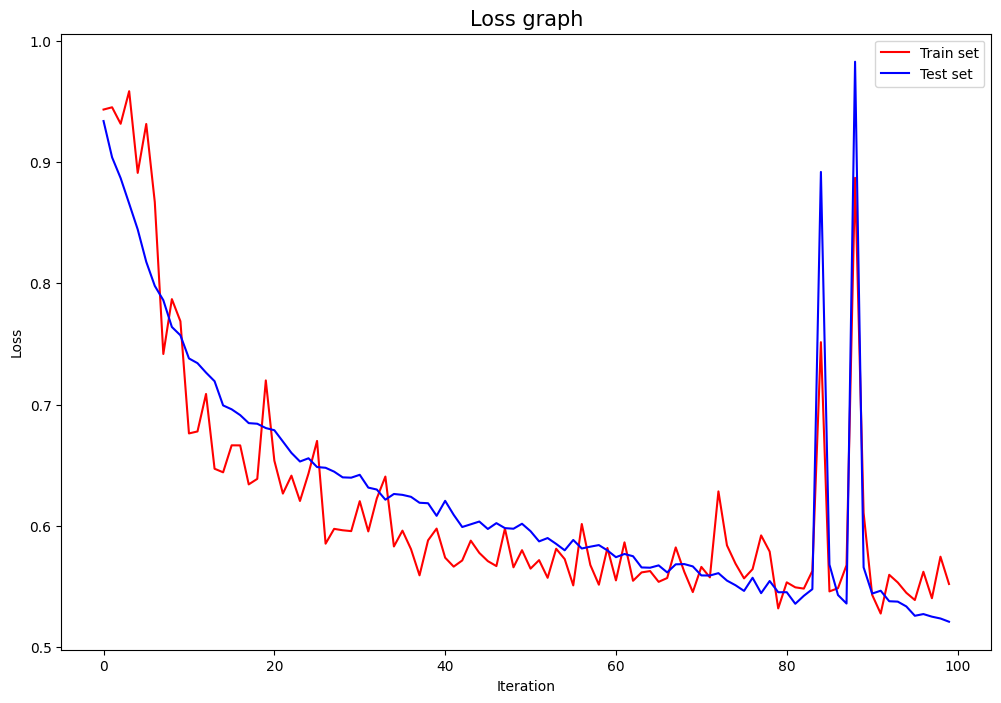

In [55]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(list_testloss, 'r-', label='Train set')
ax.plot(list_trainloss, 'b-', label='Test set')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss graph', fontsize = 15)
ax.legend(loc='best')

plt.savefig('loss-graph.jpg', dpi=400)

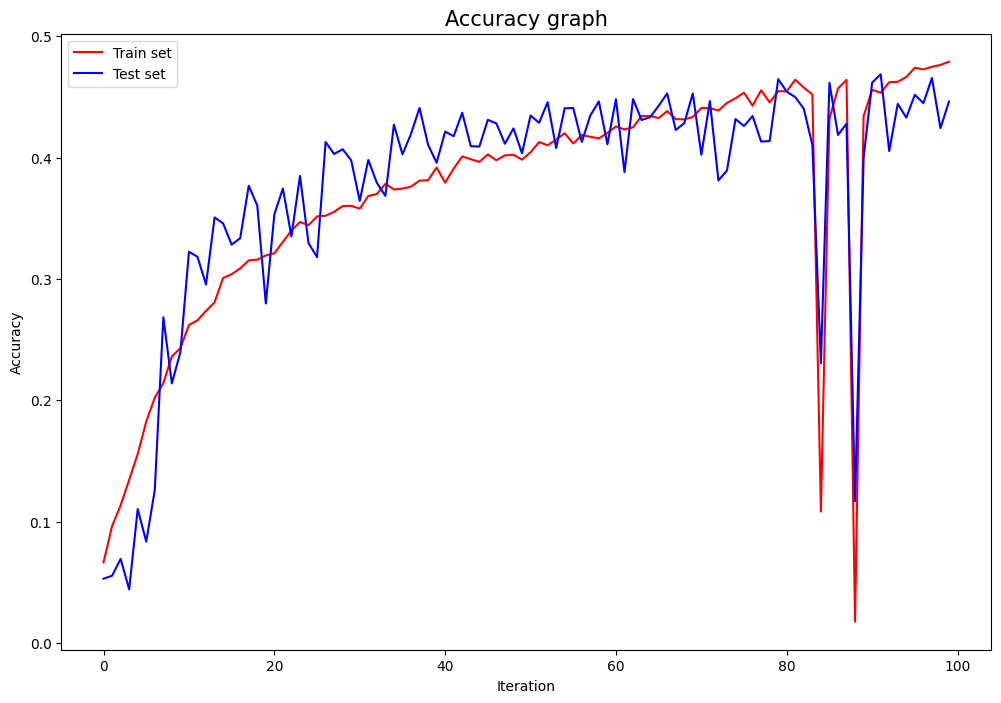

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list_traindice, 'r-', label='Train set')
ax.plot(list_testdice, 'b-', label='Test set')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy graph', fontsize = 15)
ax.legend(loc='best')
plt.savefig('accuracy-graph.jpg', dpi=400)

In [57]:
model = load_model('xxx.hdf5', custom_objects={'jac_distance': jac_distance, 'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [58]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(IMG_SIZE[0], IMG_SIZE[1]))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 912 validated image filenames.
Found 912 validated image filenames.
28/28 [==============================] - 13s 464ms/step - loss: 0.6392 - binary_accuracy: 0.9486 - iou: 0.2197 - dice_coef: 0.3594 - auc: 0.6402
Test loss:  0.6391587257385254
Test IOU:  0.9485940337181091
Test Dice Coefficent:  0.21966591477394104


1/1 [==============================] - 2s 2s/step


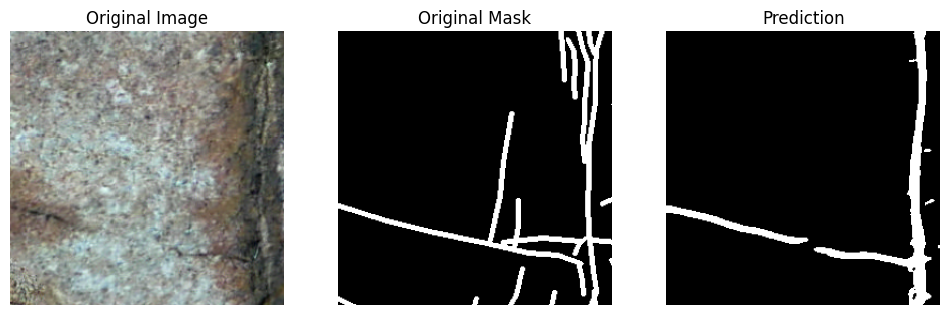

1/1 [==============================] - 0s 20ms/step


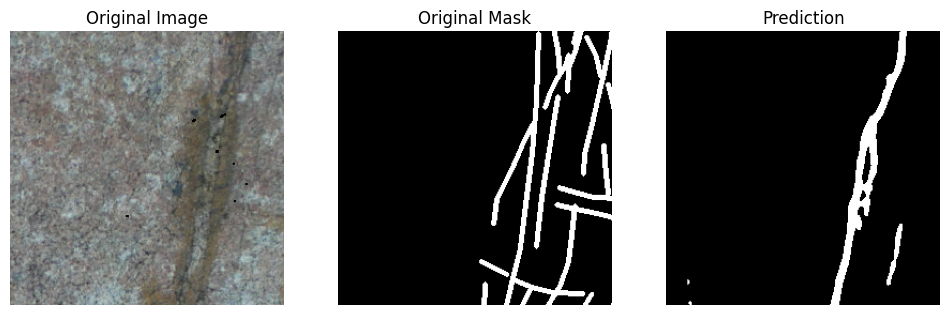

1/1 [==============================] - 0s 20ms/step


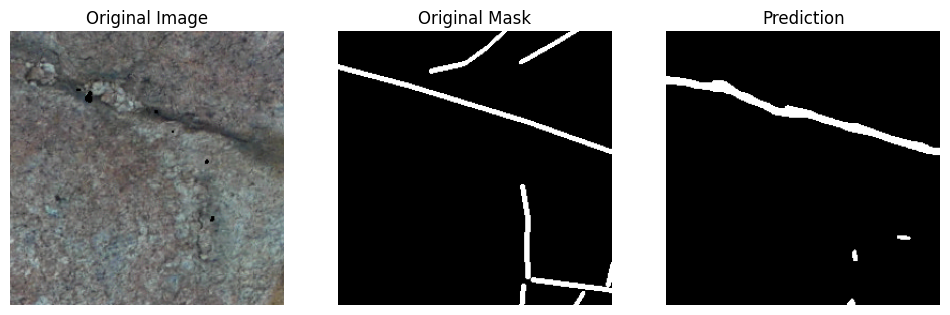

1/1 [==============================] - 0s 19ms/step


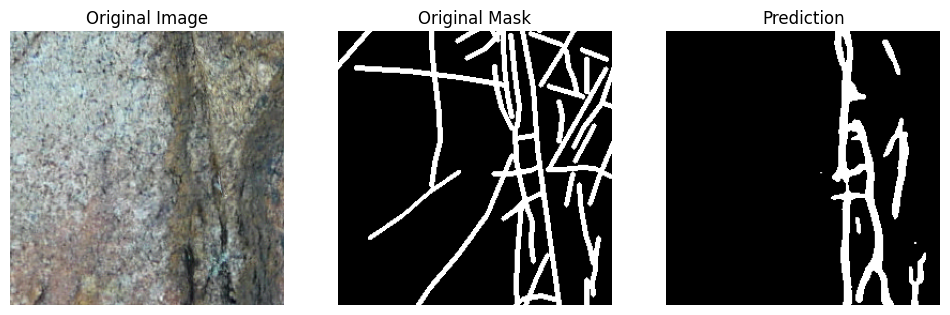

1/1 [==============================] - 0s 19ms/step


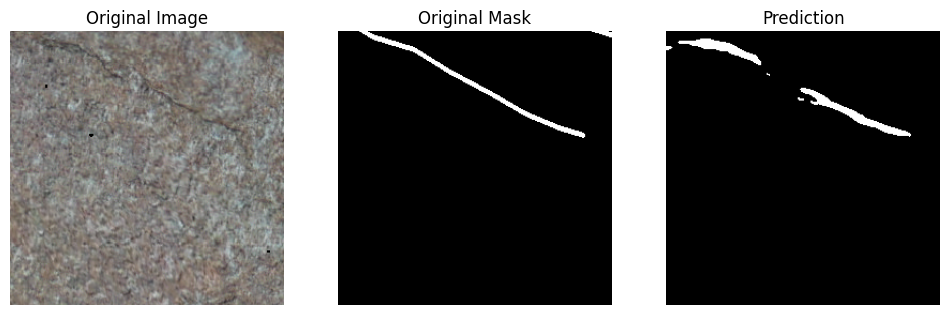

1/1 [==============================] - 0s 19ms/step


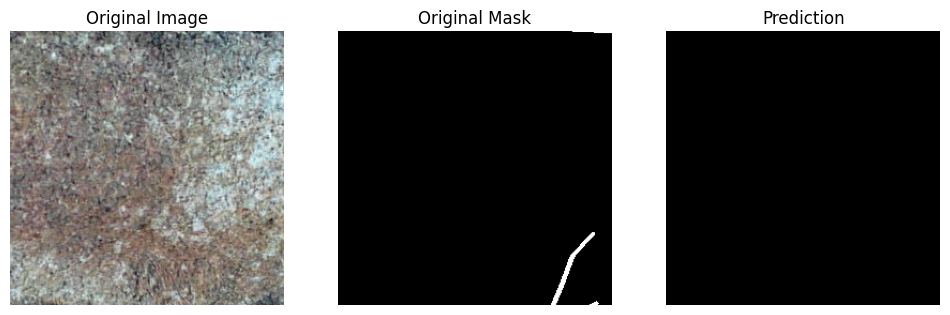

1/1 [==============================] - 0s 20ms/step


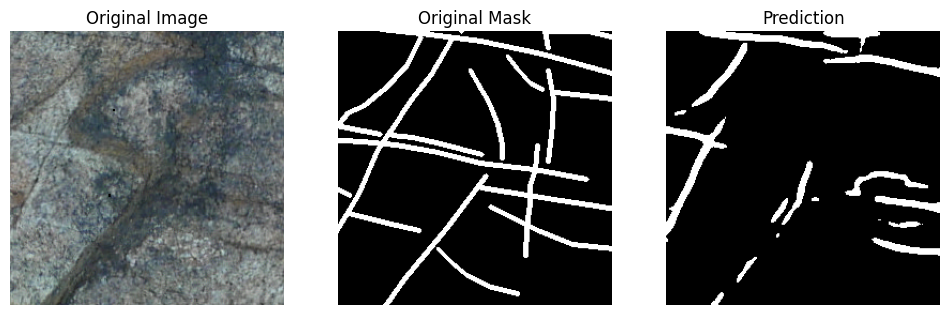

1/1 [==============================] - 0s 22ms/step


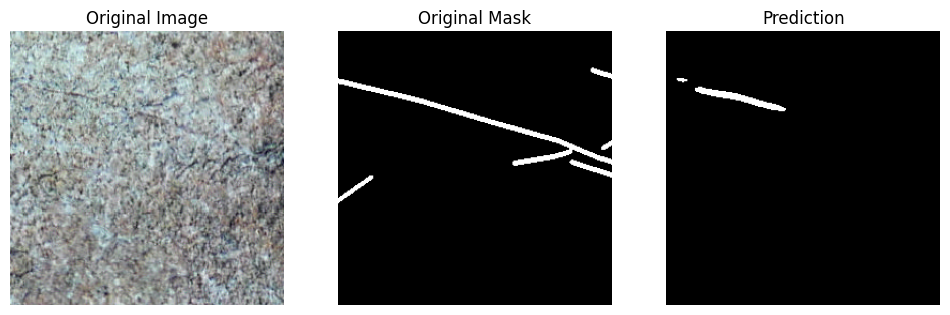

1/1 [==============================] - 0s 21ms/step


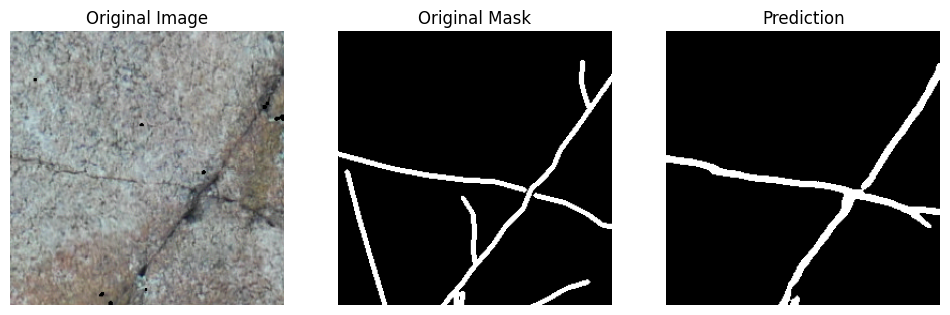

1/1 [==============================] - 0s 23ms/step


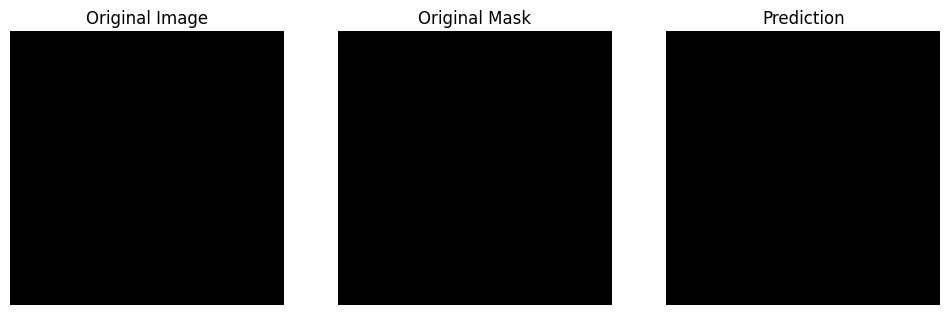

1/1 [==============================] - 0s 21ms/step


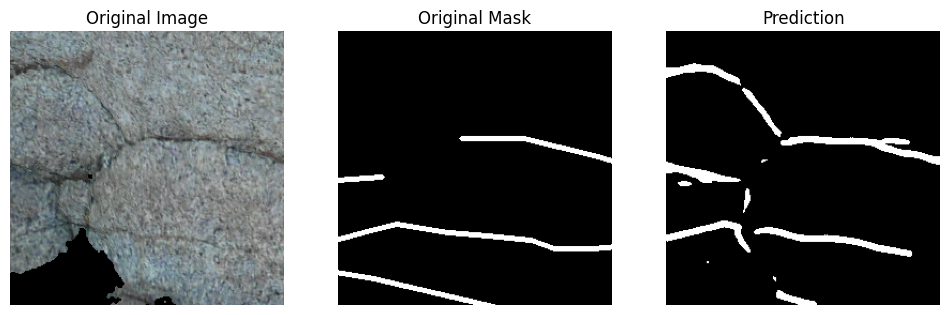

1/1 [==============================] - 0s 21ms/step


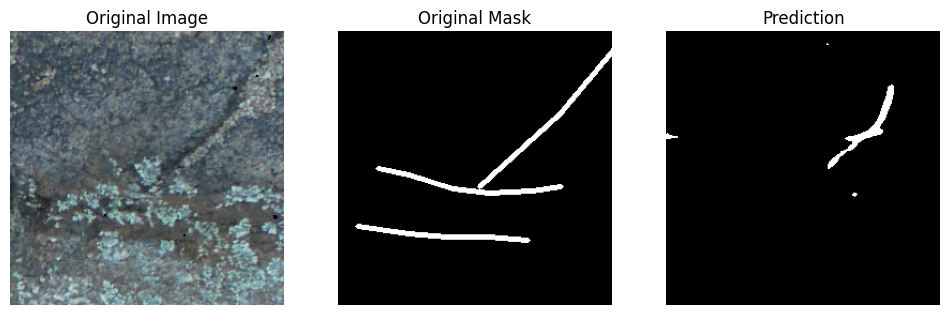

1/1 [==============================] - 0s 21ms/step


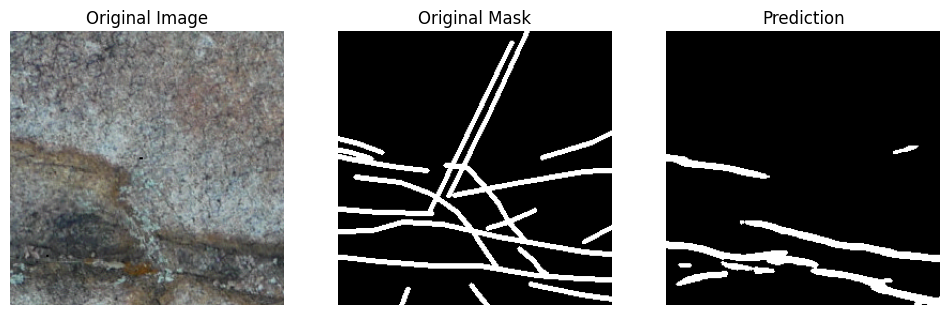

1/1 [==============================] - 0s 23ms/step


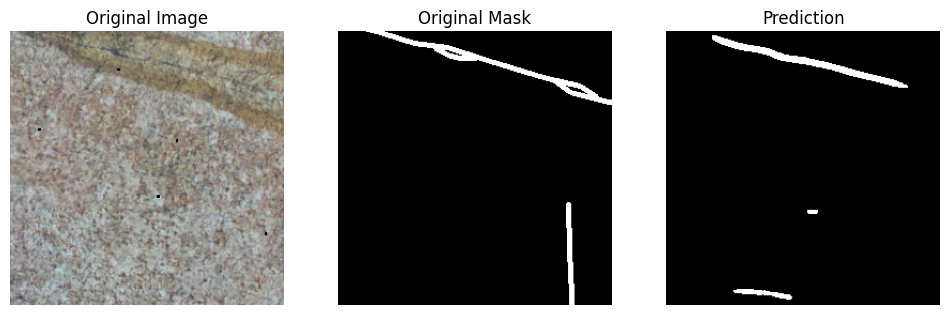

1/1 [==============================] - 0s 23ms/step


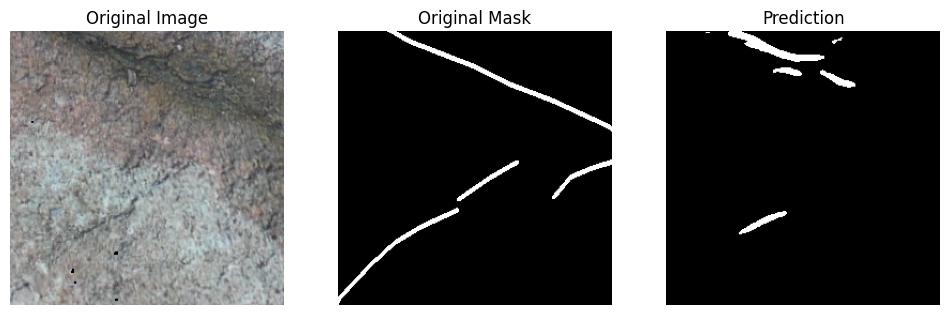

1/1 [==============================] - 0s 24ms/step


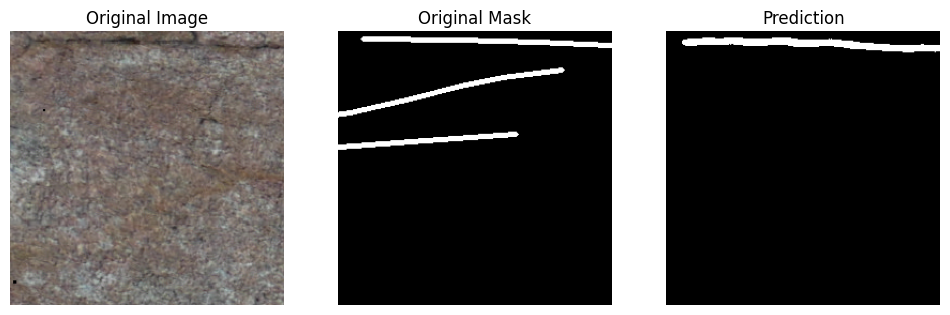

1/1 [==============================] - 0s 22ms/step


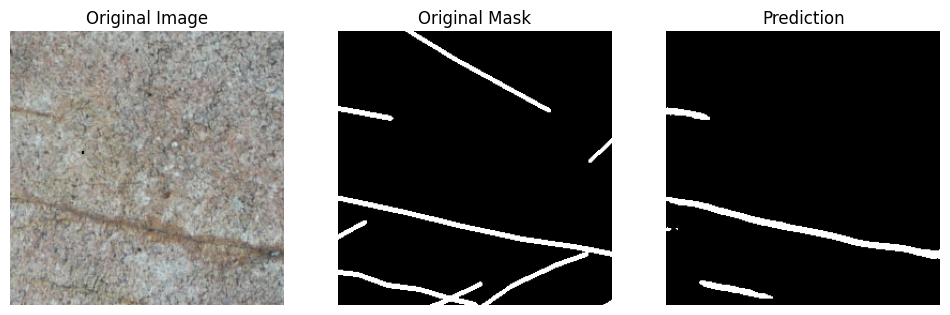

1/1 [==============================] - 0s 22ms/step


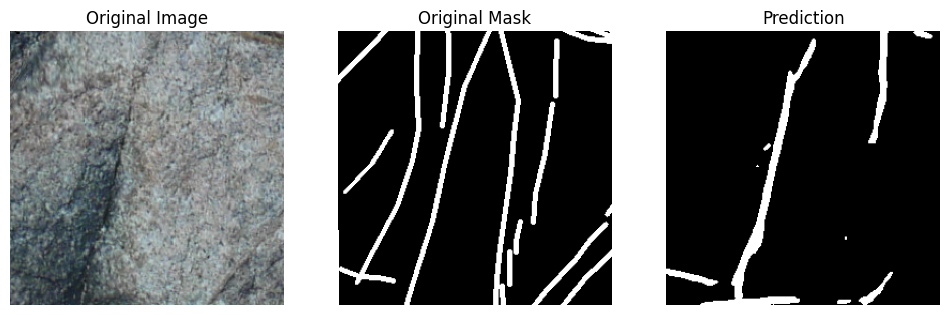

1/1 [==============================] - 0s 22ms/step


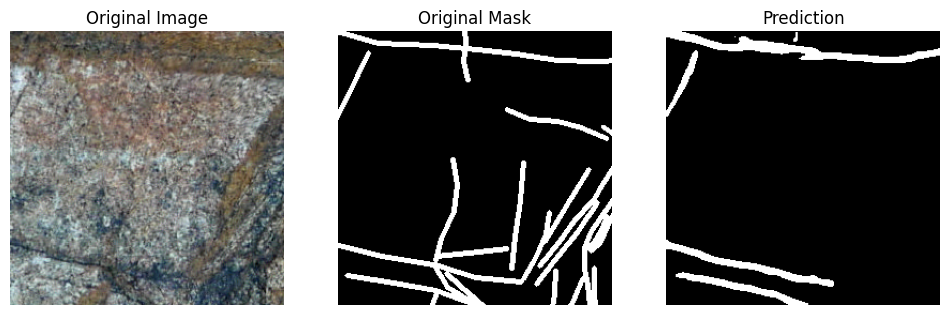

1/1 [==============================] - 0s 23ms/step


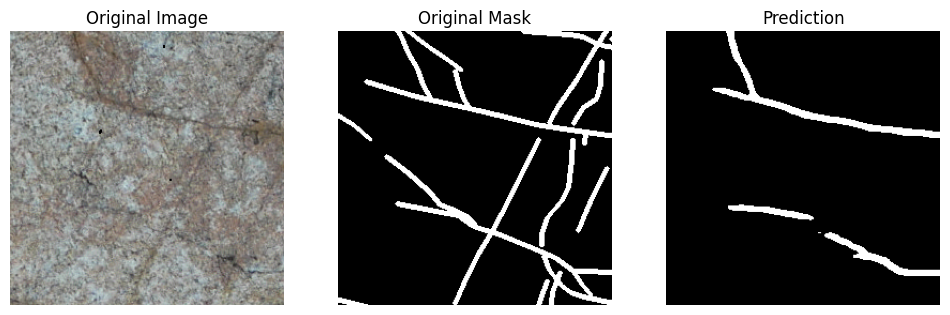

In [59]:
for i in [121, 739, 680, 179, 36, 174, 243, 53, 258, 787, 3, 728, 484, 149, 63, 23, 477, 648, 442, 482]:
    # index=np.random.randint(1,len(df_test.index))
    index = i
    img = imread(df_test['filename'].iloc[index])
    mask = imread(df_test['mask'].iloc[index])
    # adjust img and msk !
    img, mask = adjust_data(img, mask)
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(imread(df_test['filename'].iloc[index])[:, :, :3]))
    plt.title('Original Image')
    plt.axis('off')
    plt.grid('off')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(mask), cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')
    plt.grid('off')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5, cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    plt.grid('off')
    plt.show()
    # break